# 전처리 기능 개발

## 데이터 불러오기

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('./(2022.08.30) Daeshin_VL04_CurSpindle_CurX_CurZ_utf8.csv')

In [6]:
df

,datetime,tool_number,shot_no,current_spindle,current_x,current_z
0,2022-08-01 00:00:00.357458,707,6210,0,0,2
1,2022-08-01 00:00:00.523228,707,6210,0,0,2
2,2022-08-01 00:00:00.751894,707,6210,0,0,2
3,2022-08-01 00:00:00.920389,707,6210,0,0,2
4,2022-08-01 00:00:01.121784,707,6210,0,0,2
...,...,...,...,...,...,...
10381473,2022-08-25 23:59:58.993583,101,6604,2049,31,2
10381474,2022-08-25 23:59:59.224553,101,6604,2049,33,2
10381475,2022-08-25 23:59:59.393921,101,6604,2047,33,2
10381476,2022-08-25 23:59:59.599327,101,6604,2047,33,2


## 전처리

<AxesSubplot:>

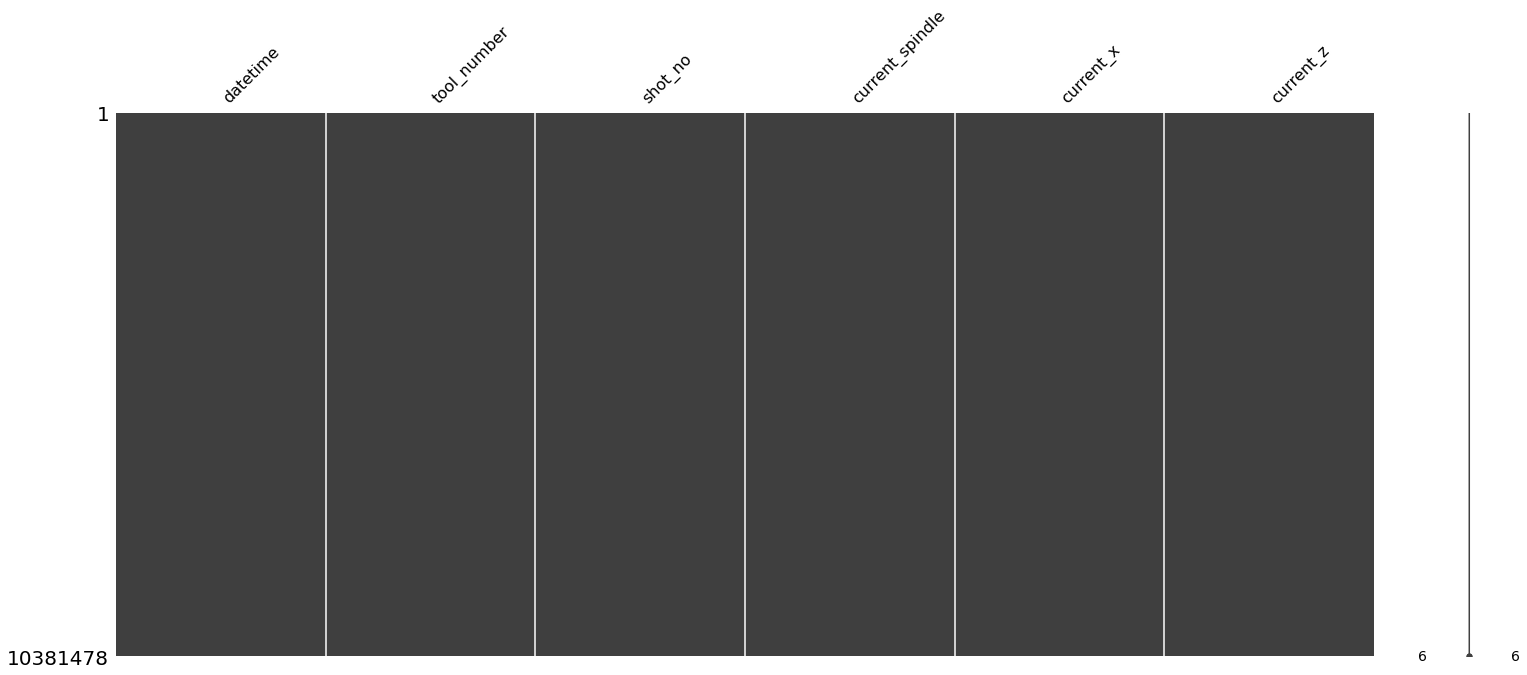

In [7]:
import missingno as msno
msno.matrix(df)

In [8]:
df.isnull().sum()

datetime           0
tool_number        0
shot_no            0
current_spindle    0
current_x          0
current_z          0
dtype: int64

In [9]:
df['shot_no'].unique()

array([6210, 6211, 6212, 6213, 6214, 6215, 6216, 6217, 6218, 6219, 6220,
       6221, 6222, 6223, 6224, 6225, 6226, 6227, 6228, 6229, 6230, 6231,
       6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241, 6242,
       6243, 6244, 6245, 6246, 6247, 6248, 6249, 6250, 6251, 6252, 6253,
       6254, 6255, 6256, 6257, 6258, 6259, 6260, 6261, 6262, 6263, 6264,
       6265, 6266, 6267, 6268, 6269, 6270, 6271, 6272, 6273, 6274, 6275,
       6276, 6277, 6278, 6279, 6280, 6281, 6282, 6283, 6284, 6285, 6286,
       6287, 6288, 6289, 6290, 6291, 6292, 6293, 6294, 6295, 6296, 6297,
       6298, 6299, 6300, 6301, 6302, 6303, 6304, 6305, 6306, 6307, 6308,
       6309, 6310, 6311, 6312, 6313, 6314, 6315, 6316, 6317, 6318, 6319,
       6320, 6321, 6322, 6323, 6324, 6325, 6326, 6327, 6328, 6329, 6330,
       6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341,
       6342, 6343, 6344, 6345, 6346, 6347, 6348, 6349, 6350, 6351, 6352,
       6353, 6354, 6355, 6356, 6357, 6358, 6359, 63

### tool_number로부터 tool 번호 및 상태 정보 추출

In [10]:
# tool 번호 및 상태 생성
df['tool_state'] = df['tool_number']%100
df['tool'] = (df['tool_number'] - df['tool_state'])/100
df['tool'] = df['tool'].astype(int)
df
tool_number_list = list(df['tool_number'].unique())

### shot 별로 사용된 공구를 순서대로 추출하여 shot과 사용 공구 순서를 pair로 하는 dataframe 생성

#### 필요한 함수 정의

In [11]:
#dataframe에 사용된 공구를 순서대로 추출해서 list형태로 반환
def extract_tool_list(data, report_result=False):
    import itertools

    tool_list = []
    #print([(k, (g)) for k, g in itertools.groupby(df_shot_specific['tool'])])
    for k, g in itertools.groupby(data['tool']):
        tool_list.append(k)

    if report_result is True:
        print(tool_list)
    
    return tool_list

In [12]:
#dataframe에서 (1) 주어진 shot_no에 해당하는 데이터를 추출한 후, (2) 해당 데이터에 사용된 공구를 순서대로 가져와서 반환
def extract_tool_list_of_specific_shot(data, shot_no, report_result=False):
    df_shot = data[data['shot_no'] == shot_no]
    
    if report_result is True:
        print("===== shot{} ============================\n\n(1) dataframe -----------------\n".format(shot_no))
        print(df_shot)
        print("(2) used tool -----------------\n")
        print(df_shot['tool'].unique())
        print("(3) extract order using tools -----------------\n")
    return extract_tool_list(df_shot, report_result)

In [13]:
#dataframe에서 전체 shot에 대해 아래의 과정 수행
#   - 각 shot 별로 사용된 공구 순서를 추출
#   - shot & 공구 사용 순서정보를 column으로 하는 dataframe을 구성한 후 반환
def extract_tool_list_of_all_shots(data, report_result=False):
    column_names = ['shot_no', 'order_using_tool']
    df_by_shot = pd.DataFrame(columns=column_names)
    row = 0

    for shot in df['shot_no'].unique():
        tool_list = extract_tool_list_of_specific_shot(df, shot, report_result)
        str_tool_list = ' '.join(map(str, tool_list))
        df_by_shot.loc[row] = [shot, str_tool_list]
        row += 1

    print(df_by_shot)
    
    return df_by_shot

#### 테스트

In [14]:
#테스트 : 6413번 shot에 대한 공구 사용 순서 추출
extract_tool_list_of_specific_shot(df, 6413, report_result=True)

#테스트 : 6357번 shot에 대한 공구 사용 순서 추출
extract_tool_list_of_specific_shot(df, 6357, report_result=True)

===== shot6413 ============================

(1) dataframe -----------------

                           datetime  tool_number  shot_no  current_spindle  \
6657850  2022-08-17 08:50:06.076249          707     6413             4460   
6657851  2022-08-17 08:50:06.329901          707     6413              140   
6657852  2022-08-17 08:50:06.490129          707     6413              140   
6657853  2022-08-17 08:50:06.689529          707     6413              140   
6657854  2022-08-17 08:50:06.906734          707     6413              140   
...                             ...          ...      ...              ...   
6684674  2022-08-17 10:19:38.357815          707     6413             6498   
6684675  2022-08-17 10:19:38.529615          707     6413             6498   
6684676  2022-08-17 10:19:38.729615          707     6413             6313   
6684677  2022-08-17 10:19:38.924438          707     6413             6313   
6684678  2022-08-17 10:19:39.152132          707     6413       

[1, 5, 9, 11, 7, 3, 11, 7]

#### shot no.와 해당 shot에 사용된 공구 순서 정보를 가지는 dataframe 생성

In [18]:
#전체 shot에 대한 공구 사용 순서를 추출하여 dataframe 구성
df_by_shot = extract_tool_list_of_all_shots(df)

    shot_no     order_using_tool
0      6210  7 1 5 9 11 7 3 11 7
1      6211                    7
2      6212                    7
3      6213                    7
4      6214                  7 1
..      ...                  ...
390    6600  7 1 5 9 11 7 3 11 7
391    6601  7 1 5 9 11 7 3 11 7
392    6602  7 1 5 9 11 7 3 11 7
393    6603  7 1 5 9 11 7 3 11 7
394    6604                  7 1

[395 rows x 2 columns]


#### shot 별 공구 사용 순서 패턴 추출

In [32]:
#공구 사용 순서 패턴 추출
df_by_shot['order_using_tool'].unique()

array(['7 1 5 9 11 7 3 11 7', '7', '7 1', '1', '1 5 9 11 7 3 11 7',
       '7 1 5 9 1 5 9 11 7 3 11 7', '7 1 5 7 11 1 5 9 11 7 3 11 7',
       '7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7', '7 1 5 9 11 7 1 3 11 7',
       '7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7',
       '7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7',
       '1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7',
       '7 1 7 1 5 9 11 7 3 11 7'], dtype=object)

In [33]:
len(df_by_shot['order_using_tool'].unique())

13

#### 공구 사용 패턴의 정상/오류 판별

##### (1) 공구 사용 패턴 : 정상

In [23]:
#(1-1) 정상 가공 패턴(1-5-9-11-7-3-11-7) 1회 수행
#---- 정상 여부 : 정상
df_by_shot[df_by_shot['order_using_tool'] == '1 5 9 11 7 3 11 7']

,shot_no,order_using_tool
7,6217,1 5 9 11 7 3 11 7
26,6236,1 5 9 11 7 3 11 7
122,6332,1 5 9 11 7 3 11 7
147,6357,1 5 9 11 7 3 11 7
178,6388,1 5 9 11 7 3 11 7
226,6436,1 5 9 11 7 3 11 7
247,6457,1 5 9 11 7 3 11 7
268,6478,1 5 9 11 7 3 11 7
294,6504,1 5 9 11 7 3 11 7


In [21]:
#(1-2) 맨처음 Tool7 사용한 후 정상 가공 패턴(1-5-9-11-7-3-11-7) 1회 수행
#---- 정상 여부 : 정상
#---- 처리 방안 : 맨 앞의 Tool7에 해당하는 데이터 삭제 후 사용
df_by_shot[df_by_shot['order_using_tool'] == '7 1 5 9 11 7 3 11 7']

,shot_no,order_using_tool
0,6210,7 1 5 9 11 7 3 11 7
8,6218,7 1 5 9 11 7 3 11 7
9,6219,7 1 5 9 11 7 3 11 7
10,6220,7 1 5 9 11 7 3 11 7
11,6221,7 1 5 9 11 7 3 11 7
...,...,...
389,6599,7 1 5 9 11 7 3 11 7
390,6600,7 1 5 9 11 7 3 11 7
391,6601,7 1 5 9 11 7 3 11 7
392,6602,7 1 5 9 11 7 3 11 7


In [27]:
#(1-3) 맨 처음 Tool7 사용 후 정상 가공 패턴(1-5-9-11-7-3-11-7) 2번 반복
#---- 정상 여부 : 정상
#---- 처리 방안 : 맨 앞의 Tool7에 해당하는 데이터 삭제 후 2개의 shot으로 분리
df_by_shot[df_by_shot['order_using_tool'] == '7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7']

,shot_no,order_using_tool
19,6229,7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7
38,6248,7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7
51,6261,7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7
56,6266,7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7
75,6285,7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7
84,6294,7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7
100,6310,7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7
108,6318,7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7
163,6373,7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7
180,6390,7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7


In [40]:
#(1-4) 맨 처음 Tool7 사용 후 정상 가공 패턴(1-5-9-11-7-3-11-7) 4번 반복
#---- 정상 여부 : 정상
#---- 처리 방안 : 맨 앞의 Tool7에 해당하는 데이터 삭제 후 4개의 shot으로 분리
df_by_shot[df_by_shot['order_using_tool'] == '7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7']

,shot_no,order_using_tool
39,6249,7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7 1 5 9 11...


In [41]:
#(1-5) 맨 처음 Tool7 사용 후 정상 가공 패턴(1-5-9-11-7-3-11-7) 3번 반복
#---- 정상 여부 : 정상
#---- 처리 방안 : 맨 앞의 Tool7에 해당하는 데이터 삭제 후 3개의 shot으로 분리
df_by_shot[df_by_shot['order_using_tool'] == '7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7']

,shot_no,order_using_tool
129,6339,7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7 1 5 9 11...
331,6541,7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7 1 5 9 11...


In [42]:
#(1-6) 정상 가공 패턴(1-5-9-11-7-3-11-7) 3번 반복
#---- 정상 여부 : 정상
#---- 처리 방안 : 3개의 shot으로 분리
df_by_shot[df_by_shot['order_using_tool'] == '1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7']

,shot_no,order_using_tool
307,6517,1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7 1 5 9 11 7...


##### (2) 공구 사용 패턴 : 오류 → 삭제 필요

In [25]:
#(2-1) Tool7만 사용
#---- 정상 여부 : 오류
#---- 처리 방안 : 삭제
df_by_shot[df_by_shot['order_using_tool'] == '7']

,shot_no,order_using_tool
1,6211,7
2,6212,7
3,6213,7
50,6260,7
72,6282,7
73,6283,7
98,6308,7
134,6344,7
200,6410,7
201,6411,7


In [35]:
#(2-2) Tool1만 사용
#---- 정상 여부 : 오류
#---- 처리 방안 : 삭제
df_by_shot[df_by_shot['order_using_tool'] == '1']

,shot_no,order_using_tool
5,6215,1
6,6216,1
24,6234,1
25,6235,1
145,6355,1
146,6356,1
225,6435,1
293,6503,1
306,6516,1


In [34]:
#(2-3) 7-1 순으로 사용
#---- 정상 여부 : 오류
#---- 처리 방안 : 삭제
df_by_shot[df_by_shot['order_using_tool'] == '7 1']

,shot_no,order_using_tool
4,6214,7 1
23,6233,7 1
121,6331,7 1
144,6354,7 1
177,6387,7 1
224,6434,7 1
246,6456,7 1
267,6477,7 1
292,6502,7 1
305,6515,7 1


In [38]:
#(2-4) 정상 가공 패턴(1-5-9-11-7-3-11-7) 없음
#---- 정상 여부 : 오류
#---- 처리 방안 : 삭제
df_by_shot[df_by_shot['order_using_tool'] == '7 1 5 9 11 7 1 3 11 7']

,shot_no,order_using_tool
35,6245,7 1 5 9 11 7 1 3 11 7


##### (3) 공구 사용 패턴 : 오류 → 처리 방안 검토 필요

In [26]:
#(3-1) 7-1-5-9 순으로 공구 사용 한 후 정상 가공 패턴(1-5-9-11-7-3-11-7)
#---- 정상 여부 : ★검토필요★
#---- 처리 방안 : ★검토필요★
df_by_shot[df_by_shot['order_using_tool'] == '7 1 5 9 1 5 9 11 7 3 11 7']

,shot_no,order_using_tool
15,6225,7 1 5 9 1 5 9 11 7 3 11 7


In [36]:
#(3-2) 7-1-5-7-11 순으로 공구 사용 한 후 정상 가공 패턴(1-5-9-11-7-3-11-7)
#---- 정상 여부 : ★검토필요★
#---- 처리 방안 : ★검토필요★
df_by_shot[df_by_shot['order_using_tool'] == '7 1 5 7 11 1 5 9 11 7 3 11 7']

,shot_no,order_using_tool
16,6226,7 1 5 7 11 1 5 9 11 7 3 11 7


In [42]:
#(3-3) 7-1-7 순으로 공구 사용 한 후 정상 가공 패턴(1-5-9-11-7-3-11-7)
#---- 정상 여부 : ★검토필요★
#---- 처리 방안 : ★검토필요★
df_by_shot[df_by_shot['order_using_tool'] == '7 1 7 1 5 9 11 7 3 11 7']

,shot_no,order_using_tool
307,6517,1 5 9 11 7 3 11 7 1 5 9 11 7 3 11 7 1 5 9 11 7...
